In [1]:
import pandas

In [2]:
CELL_FILE = "smo_data/cell_type_classification_filtered.csv"
SYNAPSE_FILE = "smo_data/synapse_filtered.csv"
MITO_FOLDER = "smo_data/microns_cells/"
MORPHOLOGY_FOLDER = "smo_data/cell_morphologies/"


In [3]:
cell_df = pandas.read_csv(CELL_FILE)

cell_ids = cell_df["cell_id"].values

In [4]:
syn_df = pandas.read_csv(SYNAPSE_FILE, index_col=0)

In [5]:
# demo: look for the inhibitory cell with most connections on a single excitatory cell
ie_syns = syn_df.loc[
    syn_df["pre_root_id"].isin(cell_df.query("cell_type=='inhibitory'")["cell_id"].values)
    & syn_df["post_root_id"].isin(cell_df.query("cell_type=='pyramidal'")["cell_id"].values)
].query("synapse_type=='pre'")\
.groupby(by=["cell_id", "post_root_id"])\
.apply(lambda df: pandas.Series({"number": len(df)}))\

selected_pair = ie_syns.loc[ie_syns.idxmax()]


In [6]:
selected_pair

,,number
cell_id,post_root_id,
648518346349528994,648518346349540055,21


In [7]:
import navis
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_cell(cell_id):
    # load neuron morphology
    neuron = navis.read_swc(os.path.join(MORPHOLOGY_FOLDER, "{:d}.swc".format(cell_id)), units="nanometer")
    
    # extract synaptic positions
    pre_syn_xyz = syn_df.query("synapse_type=='pre'").query("cell_id==@cell_id")[["x", "y", "z"]].values
    post_syn_xyz = syn_df.query("synapse_type=='post'").query("cell_id==@cell_id")[["x", "y", "z"]].values
    
    # load and extract mitochondrial positions
    def load_mito_positions(cell_id, cell_type):
        mito_df = pandas.read_csv(os.path.join(MITO_FOLDER,"{:s}_{:d}.csv".format(cell_type, cell_id)), index_col=0)
        mito_xyz = mito_df[["x", "y", "z"]].values
        return mito_xyz
    mito_xyz = load_mito_positions(cell_id, cell_df.query("cell_id==@cell_id")["cell_type"].values[0])
    
    # simple visualisation
    fig, axes = plt.subplots(2,2, sharex="col", sharey="row",gridspec_kw={"height_ratios":[1,2], "width_ratios": [1,2]})

    ax=axes[1,1]
    navis.plot2d(neuron, ax=ax, view=("x", "y"), method="2d", soma=False, scalebar="10 um")
    ax.scatter(pre_syn_xyz[:,0], pre_syn_xyz[:,1], s=1, zorder=4, label="pre")
    ax.scatter(post_syn_xyz[:,0], post_syn_xyz[:,1], s=1, zorder=4, label="post", color="blue")
    ax.scatter(mito_xyz[:,0], mito_xyz[:,1], s=1, zorder=4, label="mito", color="red")

    ax=axes[1,0]
    navis.plot2d(neuron, ax=ax, view=("z", "y"), method="2d", soma=False, scalebar="10 um")
    ax.scatter(pre_syn_xyz[:,2], pre_syn_xyz[:,1], s=1, zorder=4, label="pre")
    ax.scatter(post_syn_xyz[:,2], post_syn_xyz[:,1], s=1, zorder=4, label="post", color="blue")
    ax.scatter(mito_xyz[:,2], mito_xyz[:,1], s=1, zorder=4, label="mito", color="red")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_xlabel("z")
    ax.set_ylabel("y")

    ax=axes[0,1]
    navis.plot2d(neuron, ax=ax, view=("x", "z"), method="2d", soma=False, scalebar="10 um")
    ax.scatter(pre_syn_xyz[:,0], pre_syn_xyz[:,2], s=1, zorder=4, label="pre")
    ax.scatter(post_syn_xyz[:,0], post_syn_xyz[:,2], s=1, zorder=4, label="post", color="blue")
    ax.scatter(mito_xyz[:,0], mito_xyz[:,2], s=1, zorder=4, label="mito", color="red")
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    leg = ax.legend(bbox_to_anchor=(-0.1, 1), loc="upper right")
    leg.get_texts()[0].set_text("{:d}".format(cell_id))
    ax=axes[0,0]
    ax.axis("off")
    return fig

In [8]:
cell_id = selected_pair.index.get_level_values("cell_id").values[0]

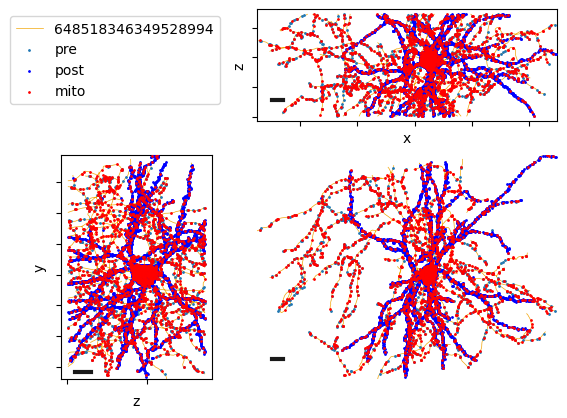

In [9]:
_=plot_cell(cell_id)

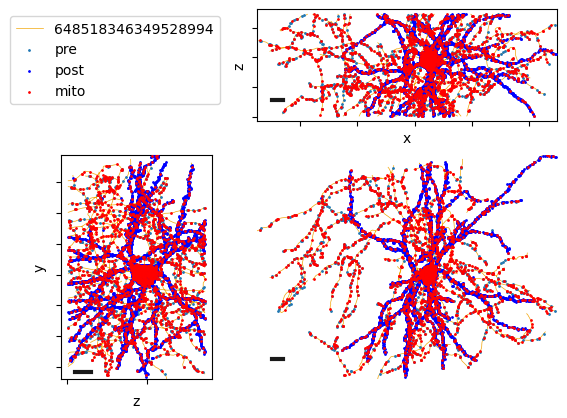

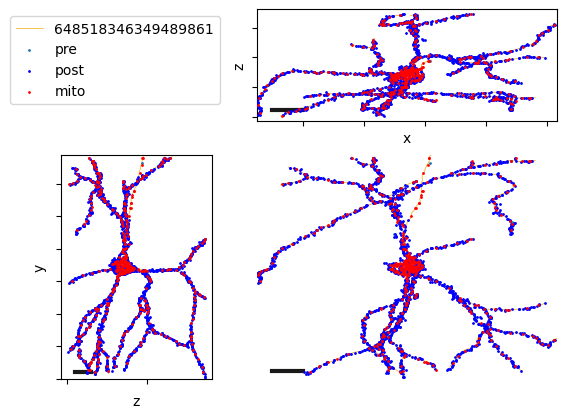

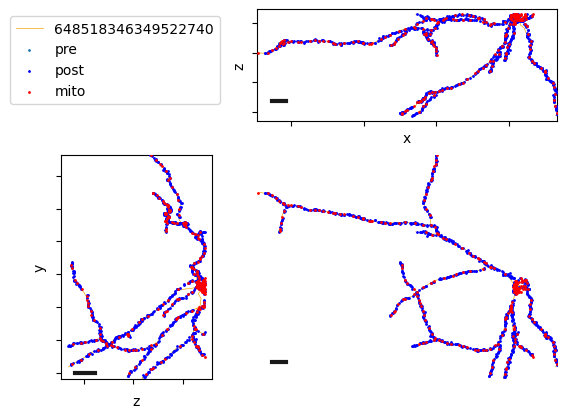

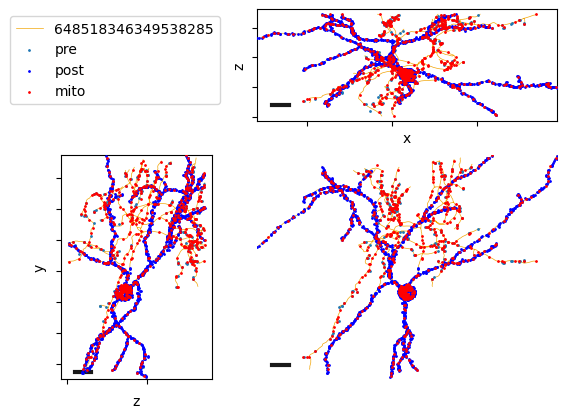

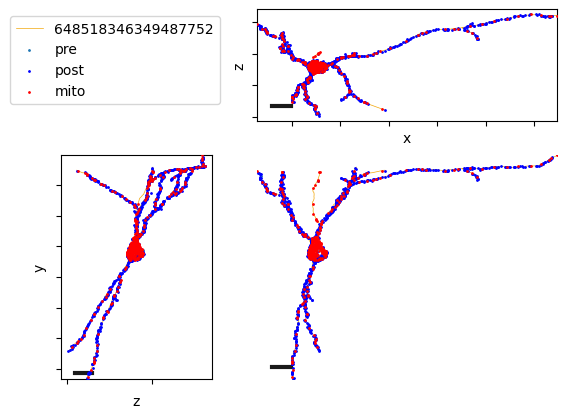

In [10]:
for cell_id in cell_df.query("cell_type=='inhibitory'").head(5)["cell_id"].values:
    plot_cell(cell_id)

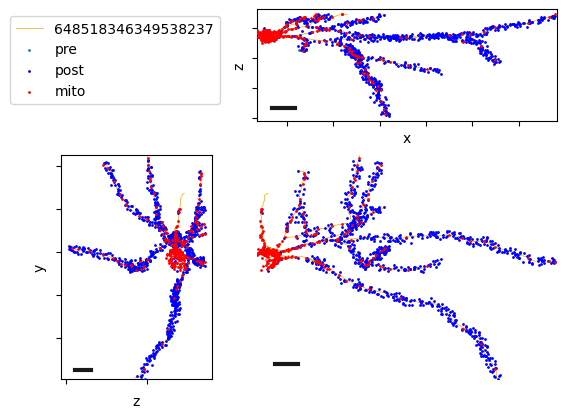

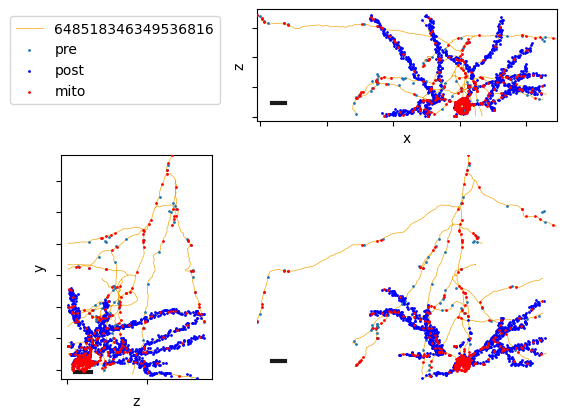

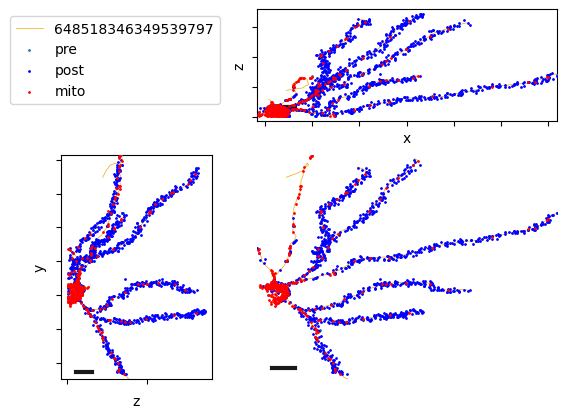

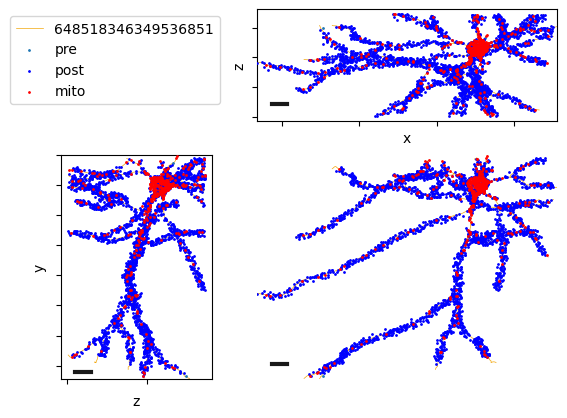

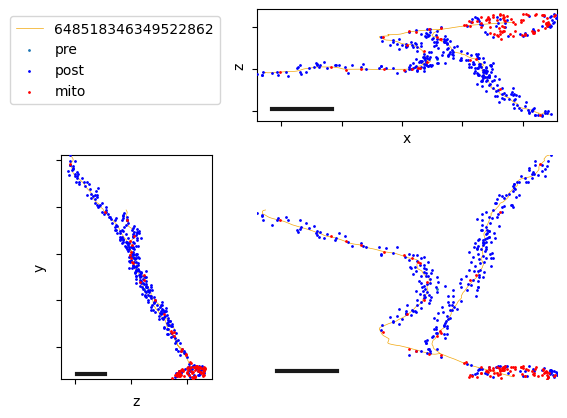

In [11]:
for cell_id in cell_df.query("cell_type=='pyramidal'").head(5)["cell_id"].values:
    plot_cell(cell_id)